# Hallucination Score Analysis

In this notebook, the hallucination scores of the methods are analyzed.

In [25]:
import glob
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import json
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, f1_score, precision_score, recall_score
from sklearn.preprocessing import binarize
from scipy.stats import chi2_contingency


## Utility Functions

In [26]:
# LOADING
# load the dataframes and durations from the results folder
def load_dataframes(f):
    dataset_name = f.split("__")[0].split("_")[-4]
    model_name = f.split(dataset_name)[0].split("\\")[-1] +"_"+ f.split("__")[-1].split(".")[0]
    df = pd.read_csv(f)
    df.drop([col for col in df.columns if "answer" in col or "prompt" in col], axis=1, inplace=True)
    durations = f.split(dataset_name)[0] + "durations.csv"
    durations_df = pd.read_csv(durations) if len(glob.glob(durations)) > 0 else None
    return {"dataset_name": dataset_name, "model": model_name, "df": df, "durations": durations_df}


# ______________
# PREPROCESSING
# fix json errors in the column lbhd_score
def fix_json_errors(df):
    count = 0
    for index, row in df.iterrows():
        json_str = row['lbhd_score'].replace("'", "\"")
        while True:
            try:
                # Attempt to parse the JSON string
                json.loads(json_str)
                break  # Exit the loop if no error
            except json.JSONDecodeError as e:
                # If there's a JSONDecodeError, extract the position of the error
                error_pos = e.pos
                # print(f"Fixing error in row {index} at position: {error_pos}")
                # Add a backslash to the string in front of the error to escape the character
                json_str = json_str[:error_pos - 1] + "\\" + json_str[error_pos - 1:]
                # Replace the JSON string in the DataFrame with the corrected one
                df.at[index, 'lbhd_score'] = json_str
                count += 1
    print(f"Fixed {count} JSON errors\n")
    return df

# normalize the columns
def normalize_column(column):
    # Apply Min-Max normalization
    column = (column - column.min()) / (column.max() - column.min())
    # rescale to [0, 1] range (from [-1, 1] range)
    column = (column + 1) / 2
    return column

# process the lbhd_score column
def process_lbhd_scores(df):
    # Initialize new columns with default values
    df['lbhd_sent_avg'] = 0.0
    df['lbhd_sent_min'] = 0.0
    df['lbhd_sent_normalized_product'] = 0.0
    df['lbhd_concept_avg'] = 0.0
    df['lbhd_concept_min'] = 0.0
    df['lbhd_concept_normalized_product'] = 0.0
    # Iterate over each row to process the 'lbhd_score' column
    for index, row in df.iterrows():
        # Parse the string representation of the dictionary into an actual dictionary
        lbhd_score = json.loads(row['lbhd_score'].replace("'", "\""))        
        # Extract the low-level scores
        df.at[index, 'lbhd_sent_avg'] = lbhd_score['avg']
        df.at[index, 'lbhd_sent_min'] = lbhd_score['min']
        df.at[index, 'lbhd_sent_normalized_product'] = lbhd_score['normalized_product']        
        # Aggregate the concept-level scores
        concept_avgs = [concept[next(iter(concept))]['avg'] for concept in lbhd_score['concepts']]
        concept_mins = [concept[next(iter(concept))]['min'] for concept in lbhd_score['concepts']]
        concept_norm_prods = [concept[next(iter(concept))]['normalized_product'] for concept in lbhd_score['concepts']]        
        df.at[index, 'lbhd_concept_avg'] = np.mean(concept_avgs)
        df.at[index, 'lbhd_concept_min'] = np.min(concept_mins)
        def normalized_product(probabilities):
            adjusted_probs = [max(p, 1e-30) for p in probabilities]
            log_probs = np.log(adjusted_probs)
            score = np.exp(np.sum(log_probs) / len(adjusted_probs))
            return score
        df.at[index, 'lbhd_concept_normalized_product'] = normalized_product(concept_norm_prods)
    # Remove the 'lbhd_score' column
    df.drop('lbhd_score', axis=1, inplace=True)
    # Normalize the new columns
    df['lbhd_sent_avg'] = normalize_column(df['lbhd_sent_avg'])
    df['lbhd_sent_min'] = normalize_column(df['lbhd_sent_min'])
    df['lbhd_sent_normalized_product'] = normalize_column(df['lbhd_sent_normalized_product'])
    df['lbhd_concept_avg'] = normalize_column(df['lbhd_concept_avg'])
    df['lbhd_concept_min'] = normalize_column(df['lbhd_concept_min'])
    df['lbhd_concept_normalized_product'] = normalize_column(df['lbhd_concept_normalized_product'])
    # reverse calculation of: linear_probs = [(prob + 1) / 2 for prob in linear_probs]
    for col in df.columns:
        if "lbhd" in col:
            df[col] = (df[col] * 2) - 1
            #  invert the values 
            df[col] = df[col] * -1 + 1
    return df

# Remove rows with errors
def remove_err_rows(df):
    initial_rows = len(df)
    print(f"Initial rows: {initial_rows}")
    df = df.dropna()
    # if objects, means its a string representation of a dictionary
    for col in df.columns:
        if df[col].dtype == "object":
            # remove if 'error' is first key
            df = df[~df[col].str.contains("error")]
            if len(df) < initial_rows:
                print(f"Removed {initial_rows - len(df)} rows with errors in column {col}")
            initial_rows = len(df)  # update initial_rows for the next iteration
        elif df[col].dtype == "float64":
            # remove if -1
            df = df[df[col] != -1]
            if len(df) < initial_rows:
                print(f"Removed {initial_rows - len(df)} rows with errors in column {col}")
            initial_rows = len(df)  # update initial_rows for the next iteration
    print(f"Final rows: {initial_rows}")
    return df

# preprocess datatypes
def preprocess_datatypes(df):
    # Convert 'ground_truth' to boolean
    df['ground_truth'] = df['ground_truth'].astype(bool)
    df['fleek_score'] = df['fleek_score'].astype(bool)
    return df

# ______________
# EVALUATION
# getting F1 optimal thresholds for each continuous column
def get_optimal_thresholds(df):
    thresholds = {}
    for col in df.columns:
        if df[col].dtype == "float64":
            y_true = df['ground_truth']
            y_pred = df[col]
            precision, recall, thresholds[col] = precision_recall_curve(y_true, y_pred)
    return thresholds

# # calculate the metrics
# def calculate_metrics(df):
#     metrics = {}
#     for col in df.columns:
#         if df[col].dtype == "float64":
#             y_true = df['ground_truth']
#             y_pred = df[col]
#             # calculate the optimal threshold
#             thresholds = get_optimal_thresholds(df)
#             threshold = thresholds[col][np.argmax(thresholds[col])]
#             # binarize the predictions
#             y_pred = binarize([y_pred], threshold=threshold)[0]  # specify the threshold as a keyword argument
#             # calculate the metrics
#             roc_auc = roc_auc_score(y_true, y_pred)
#             pr_auc = average_precision_score(y_true, y_pred)
#             f1 = f1_score(y_true, y_pred)
#             precision = precision_score(y_true, y_pred)
#             recall = recall_score(y_true, y_pred)
#             metrics[col] = {"roc_auc": roc_auc, "pr_auc": pr_auc, "f1": f1, "precision": precision, "recall": recall}
#         elif df[col].dtype == "bool":
#             y_true = df['ground_truth']
#             y_pred = df[col]
#             # calculate the metrics
#             roc_auc = roc_auc_score(y_true, y_pred)
#             pr_auc = average_precision_score(y_true, y_pred)
#             f1 = f1_score(y_true, y_pred)
#             precision = precision_score(y_true, y_pred)
#             recall = recall_score(y_true, y_pred)
#             metrics[col] = {"roc_auc": roc_auc, "pr_auc": pr_auc, "f1": f1, "precision": precision, "recall": recall}
#     return metrics


def calculate_metrics(df, positive_class=1):
    metrics = {}
    ground_truth = df['ground_truth'].values

    for column in df.columns:
        if column == 'ground_truth':
            continue
        score = df[column].values
        
        # Check if the column is boolean
        if np.issubdtype(score.dtype, np.bool_):
            # Handle boolean scores directly
            binarized_score = score  # No need to binarize
            auc_roc = roc_auc_score(ground_truth, score)
            auc_pr = average_precision_score(ground_truth, score)
        else:
            
            # Calculate AUC-ROC and AUC-PR
            auc_roc = roc_auc_score(ground_truth, score)
            auc_pr = average_precision_score(ground_truth, score)
            
            # Use precision_recall_curve to find an operational point if needed
            precision, recall, thresholds = precision_recall_curve(ground_truth, score, pos_label=positive_class)
            # Example: Choose a threshold (this could be based on a desired recall or precision level)
            # For demonstration, let's maximize F1 (default behavior in the original function)
            if thresholds.size > 0:
                f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-8)
                best_idx = np.argmax(f1_scores)
                threshold = thresholds[best_idx]
                binarized_score = binarize(score.reshape(1, -1), threshold=threshold).flatten()
            else:
                binarized_score = np.zeros_like(score, dtype=bool)
        
        # Calculate metrics using sklearn's average='weighted' to handle imbalance
        precision_weighted = precision_score(ground_truth, binarized_score, average='weighted')
        recall_weighted = recall_score(ground_truth, binarized_score, average='weighted')
        f1_weighted = f1_score(ground_truth, binarized_score, average='weighted')
        
        metrics[column] = {"AUC-ROC": auc_roc, "AUC-PR": auc_pr, "Precision (Weighted)": precision_weighted, "Recall (Weighted)": recall_weighted, "F1 (Weighted)": f1_weighted}
    return metrics



# ______________
# VISUALIZATION
# plot the correlation matrix
def plot_correlation_matrix(df, model_name, dataset_name, method):
    # Ensure 'ground_truth' is the last column
    columns = [col for col in df.columns if col != 'ground_truth'] + ['ground_truth']
    df = df[columns]
    # Compute the correlation matrix
    corr = df.corr(method=method)
    # Identify the 3 strongest correlations with 'ground_truth' by absolute value, excluding itself
    strongest_corr = corr['ground_truth'].drop('ground_truth').abs().nlargest(3).index.tolist()
    fig, ax = plt.subplots(figsize=(11, 5))
    cmap = "YlGnBu"
    # Draw the heatmap with the correct aspect ratio
    sns.heatmap(corr.loc[['ground_truth']], cmap=cmap, vmax=1, vmin=0, center=0.5,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},
                annot=True, fmt=".2f", annot_kws={"size": 7})
    # Highlight the columns of the 3 strongest correlations
    for strong_corr in strongest_corr:
        ax.add_patch(Rectangle((df.columns.get_loc(strong_corr), 0), 1, 1, fill=False, edgecolor='red', lw=3))
    ax.set_xticks(np.arange(len(corr.columns)) + .5)
    ax.set_xticklabels(corr.columns, rotation=45, ha="right")
    ax.set_yticklabels(['ground_truth'])
    # Set title with model and dataset names
    dataset_name = "Natural Questions" if dataset_name == "nqopen" else "XSum" if dataset_name == "xsum" else dataset_name
    plt.title(f'{method.capitalize()} Correlation Matrix for {model_name}\non dataset {dataset_name}', fontsize=16, pad=20)
    # Adjust layout to fit everything
    plt.tight_layout()
    # Display the plot
    plt.show()

# anova and violin plots
def anova_violin_plots(df, model_name, dataset_name):
    # Ensure 'ground_truth' is the last column
    columns = [col for col in df.columns if col != 'ground_truth'] + ['ground_truth']
    df = df[columns]
    # Create a new DataFrame to store the ANOVA results
    anova_results = pd.DataFrame(columns=['feature', 'f_value', 'p_value'])
    # Iterate over each feature to perform the ANOVA test
    for feature in df.columns[:-1]:
        # Perform the ANOVA test
        f_value, p_value = chi2_contingency(pd.crosstab(df[feature], df['ground_truth']))[:2]
        # Append the results to the DataFrame
        anova_results = anova_results.append({'feature': feature, 'f_value': f_value, 'p_value': p_value}, ignore_index=True)
    # Sort the results by p-value
    anova_results = anova_results.sort_values(by='p_value')
    # Plot the violin plots
    fig, ax = plt.subplots(figsize=(15, 8))
    sns.violinplot(data=df, ax=ax)
    ax.set_title(f'Violin Plots for {model_name} on dataset {dataset_name}', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
    # Display the ANOVA results
    print(anova_results)

# plot the metrics heatmap
def plot_metrics(metrics):
    # Convert metrics to DataFrame and transpose
    metrics_df = pd.DataFrame(metrics).T
    # Create a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(metrics_df, annot=True, cmap='YlGnBu')
    plt.title('Metrics Heatmap')
    plt.show()


# ______________
# MAIN
def main():
    # Load the dataframes and durations
    files = glob.glob("results/*with_ground_truths*.csv")
    dataframes = [load_dataframes(f) for f in files]
    print(f"Found {len(dataframes)} CSVs with scores and ground truths for analysis:\n")
    for dataset in dataframes:
        print(f"Dataset: {dataset['dataset_name']}")
        print(f"LLM: {dataset['model']}")
        print(f"Shape: {dataset['df'].shape}\n")
    # Remove rows with errors
    for df in dataframes:
        df['df'] = remove_err_rows(df['df'])
    # Fix the JSON errors in the 'lbhd_score' column
    for df in dataframes:
        df['df'] = fix_json_errors(df['df'])
    # Process the 'lbhd_score' column
    for df in dataframes:
        df['df'] = process_lbhd_scores(df['df'])
    # Preprocess datatypes
    for df in dataframes:
        df['df'] = preprocess_datatypes(df['df'])
    # Calculate the metrics
    for df in dataframes:
        df['metrics'] = calculate_metrics(df['df'])
    # Plot the correlation matrix
    for df in dataframes:
        plot_correlation_matrix(df['df'], df['model'], df['dataset_name'], "pearson")
    # Plot the categorical variables
    # TODO: add to the function

## Running the Analysis

In [27]:
# main()

## Loading the scores

In [28]:
# load datasets
# find all csvs with scores and ground truths
files = glob.glob("results/*with_ground_truths*.csv")

# load all csvs into a list of dataframes
datasets = [load_dataframes(f) for f in files]

print(f"Found {len(datasets)} CSVs with scores and ground truths for analysis:\n")
for dataset in datasets:
    print(f"Dataset: {dataset['dataset_name']}")
    print(f"LLM: {dataset['model']}")
    print(f"Shape: {dataset['df'].shape}\n")

Found 6 CSVs with scores and ground truths for analysis:

Dataset: nqopen
LLM: openai__gpt-3-5-turbo
Shape: (80, 6)

Dataset: xsum
LLM: openai__gpt-3-5-turbo
Shape: (80, 6)

Dataset: nqopen
LLM: togetherai_2__mistralai_Mistral-7B-Instruct-v0-1
Shape: (80, 6)

Dataset: xsum
LLM: togetherai_2__mistralai_Mistral-7B-Instruct-v0-1
Shape: (80, 6)

Dataset: nqopen
LLM: togetherai__mistralai_Mixtral-8x7B-Instruct-v0-1
Shape: (80, 6)

Dataset: xsum
LLM: togetherai__mistralai_Mixtral-8x7B-Instruct-v0-1
Shape: (80, 6)



In [29]:
test_df = datasets[0]["df"]
test_df.head(2)

,fleek_score,selfcheck_nli_score,selfcheck_bert_score,lm_v_lm_score,lbhd_score,ground_truth
0,0.0,0.049175,0.167182,0.0,"{'avg': 0.9644255675958286, 'normalized_produc...",0.0
1,0.0,0.992679,0.348210,0.0,"{'avg': 0.9406606117559376, 'normalized_produc...",0.0


In [30]:
# remove rows with errors
test_df = remove_err_rows(test_df)

Initial rows: 80
Removed 7 rows with errors in column fleek_score
Final rows: 73


In [31]:
import time

# process LBHD scores
start = time.time()
test_df = fix_json_errors(test_df)
# test_df = fix_json_errors_optimized(test_df)
print(f"Fixing JSON errors took {time.time() - start:.2f} seconds")
start = time.time()
test_df = process_lbhd_scores(test_df)   # aggregate concept-level scores and normalize (min-max)
# test_df = process_lbhd_scores_optimized(test_df)
print(f"Processing LBHD scores took {time.time() - start:.2f} seconds")
# preprocess datatypes
test_df = preprocess_datatypes(test_df)
# save processed dataframe
test_df.to_csv("results/processed.csv", index=False)
print(test_df.dtypes)
test_df.head(3)

Fixed 10 JSON errors

Fixing JSON errors took 0.01 seconds
Processing LBHD scores took 0.03 seconds
fleek_score                           bool
selfcheck_nli_score                float64
selfcheck_bert_score               float64
lm_v_lm_score                      float64
ground_truth                          bool
lbhd_sent_avg                      float64
lbhd_sent_min                      float64
lbhd_sent_normalized_product       float64
lbhd_concept_avg                   float64
lbhd_concept_min                   float64
lbhd_concept_normalized_product    float64
dtype: object


,fleek_score,selfcheck_nli_score,selfcheck_bert_score,lm_v_lm_score,ground_truth,lbhd_sent_avg,lbhd_sent_min,lbhd_sent_normalized_product,lbhd_concept_avg,lbhd_concept_min,lbhd_concept_normalized_product
0,False,0.049175,0.167182,0.0,False,0.209095,0.226733,0.161475,0.093800,0.238065,0.076432
1,False,0.992679,0.348210,0.0,False,0.354000,0.628277,0.327028,0.155962,0.167257,0.121586
2,False,0.002411,0.260011,0.0,False,0.233051,0.332993,0.188421,0.066523,0.139901,0.051941


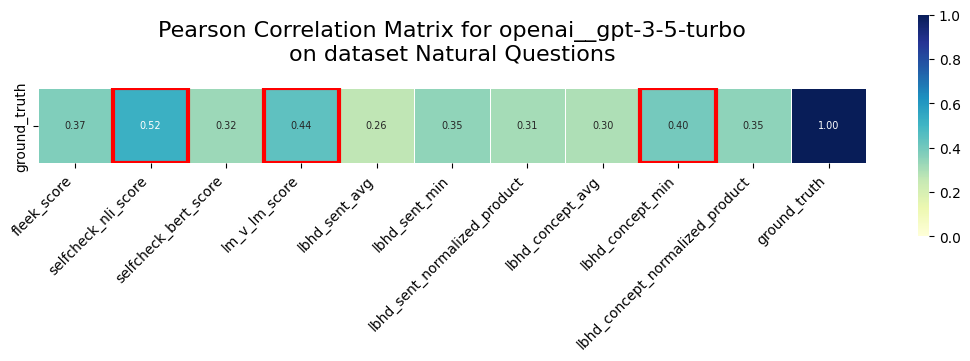

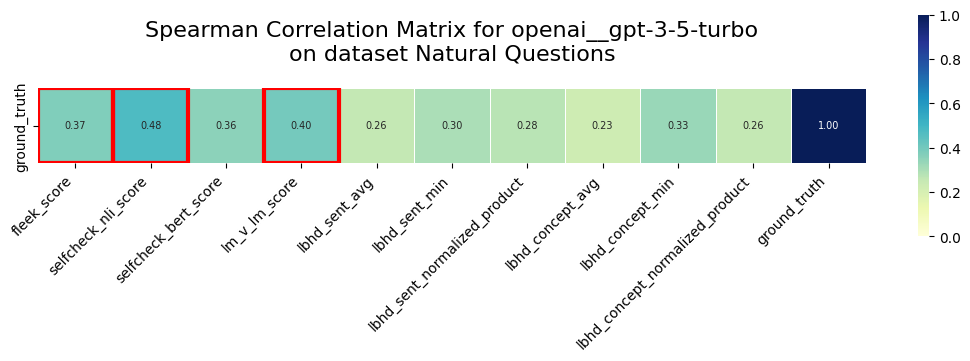

In [32]:
plot_correlation_matrix(test_df, datasets[0]["model"], datasets[0]["dataset_name"], "pearson")
plot_correlation_matrix(test_df, datasets[0]["model"], datasets[0]["dataset_name"], "spearman")
# plot_correlation_matrix(test_df, datasets[0]["model"], datasets[0]["dataset_name"], "kendall")

d:\Dev\miniconda\envs\hdetect\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


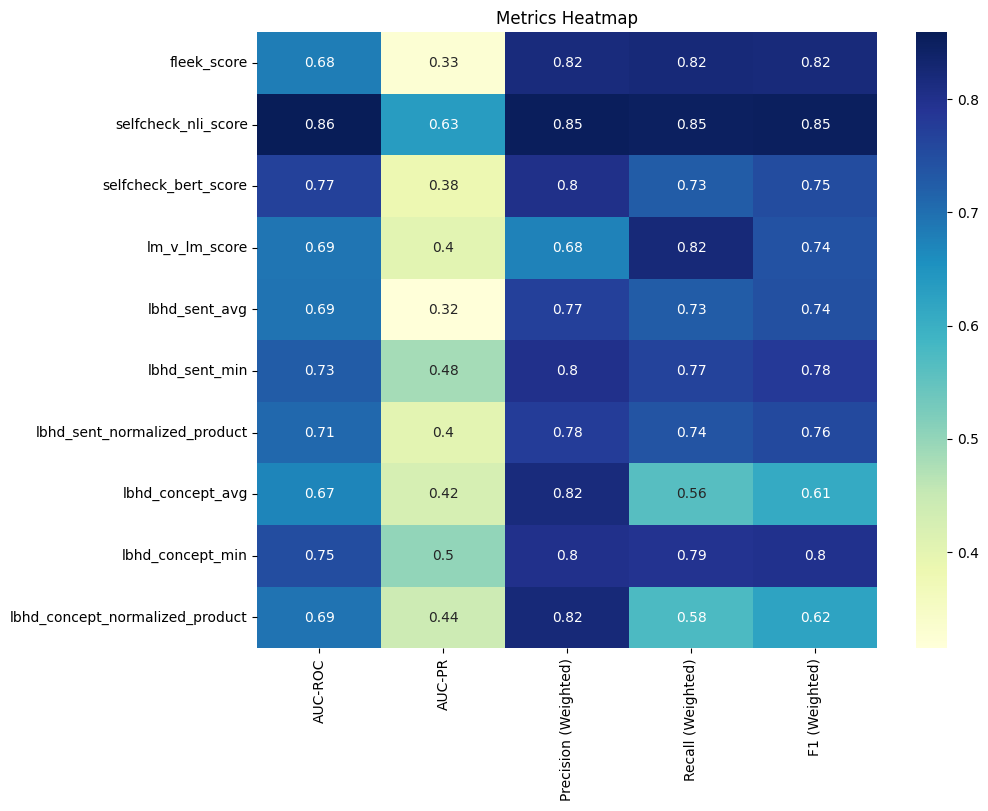

In [37]:
import seaborn as sns
# Calculate metrics for the 'lbhd_concept_min' column
metrics = calculate_metrics(test_df)
columns = test_df.columns
# Create a DataFrame from the metrics
import matplotlib.pyplot as plt




In [34]:
test_df.head(2)

,fleek_score,selfcheck_nli_score,selfcheck_bert_score,lm_v_lm_score,ground_truth,lbhd_sent_avg,lbhd_sent_min,lbhd_sent_normalized_product,lbhd_concept_avg,lbhd_concept_min,lbhd_concept_normalized_product
0,False,0.049175,0.167182,0.0,False,0.209095,0.226733,0.161475,0.093800,0.238065,0.076432
1,False,0.992679,0.348210,0.0,False,0.354000,0.628277,0.327028,0.155962,0.167257,0.121586


In [35]:
# Plot the violin plots
anova_violin_plots(test_df, datasets[0]["model"], datasets[0]["dataset_name"])

AttributeError: 'DataFrame' object has no attribute 'append'